# Forecasting UK Electricity prices with LSTM and CNN+LSTM for Multivariate time series 

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [3]:
import tensorflow as tf

In [4]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


Using TensorFlow backend.


In [5]:
df=pd.read_csv("../Data/electricity-prices.csv",index_col=[0], parse_dates=[0])
df.head(3)

,Price,Volume,Settlement Period,hour,quarter,year,dayofyear,dayofmonth,weekofyear,SAP,EU_ETS,Gas,INDO
datetime,,,,,,,,,,,,,
2017-01-01 00:00:00,44.90,505.00,1,0.0,1.0,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832,27239
2017-01-01 00:30:00,47.13,559.15,2,0.0,1.0,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832,27814
2017-01-01 01:00:00,45.62,649.35,3,1.0,1.0,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832,27453


In [77]:
def limit(data, frm, to):
    return data[(data.index>=frm)&(data.index<to)]

In [78]:
new_df = limit(df,'2019-01-01', '2019-06-30')
new_df.shape

(8530, 13)

In [79]:
new_df = new_df[['Price', 'INDO', 'Gas']]
new_df.head(3)

,Price,INDO,Gas
datetime,,,
2019-01-01 00:00:00,48.81,23712,24.560535
2019-01-01 00:30:00,50.24,24315,24.560535
2019-01-01 01:00:00,41.90,24037,24.560535


In [80]:
#new_df.to_csv('../Data/small_elec.csv')

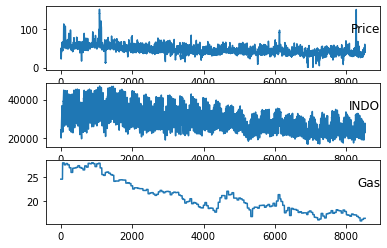

In [81]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('../Data/small_elec.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [82]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler 

In [83]:
dataset.shape

(8530, 3)

In [84]:
8530-768

7762

In [85]:
dataset.head(3)

,Price,INDO,Gas
datetime,,,
2019-01-01 00:00:00,48.81,23712,24.560535
2019-01-01 00:30:00,50.24,24315,24.560535
2019-01-01 01:00:00,41.90,24037,24.560535


In [86]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [87]:
# load dataset
dataset = pd.read_csv('../Data/small_elec.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,2] = encoder.fit_transform(values[:,2])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1,2)
# drop columns we don't want to predict
reframed.drop(reframed.columns[4:], axis=1, inplace=True)
print(reframed.head())
print(reframed.shape)

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.318158   0.229593   0.832402  0.327607
2   0.327607   0.249464   0.832402  0.272499
3   0.272499   0.240303   0.832402  0.255451
4   0.255451   0.208502   0.832402  0.220893
5   0.220893   0.179898   0.832402  0.192877
(8528, 4)


In [88]:
scaled.shape

(8530, 3)

Define and Fit model : LSTM
The example below splits the dataset into train and test sets, then splits the train and test sets into input and output variables. Finally, the inputs (X) are reshaped into the 3D format expected by LSTMs, namely [samples, timesteps, features].

In [95]:
# split into train and test sets
values = reframed.values
n_train_hours = 7808 #8064 Split_time
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1 ], train[:,-1 ]
test_X, test_y = test[:, :-1], test[:,-1 ]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(7808, 1, 3) (7808,) (720, 1, 3) (720,)


In [96]:
input_shape=train_X.shape[1], train_X.shape[2]
print(input_shape)

(1, 3)


In [97]:
df = pd.read_csv('small_elec.csv')

In [98]:
dt = df['datetime'][7810:]

In [99]:
len(dt)

720

In [102]:
dt

7810    2019-06-15 00:00:00
7811    2019-06-15 00:30:00
7812    2019-06-15 01:00:00
7813    2019-06-15 01:30:00
7814    2019-06-15 02:00:00
               ...         
8525    2019-06-29 21:30:00
8526    2019-06-29 22:00:00
8527    2019-06-29 22:30:00
8528    2019-06-29 23:00:00
8529    2019-06-29 23:30:00
Name: datetime, Length: 720, dtype: object

## LSTM algorithm: for multivariate time series 

Train on 7808 samples, validate on 720 samples
Epoch 1/50
7808/7808 - 1s - loss: 0.1009 - val_loss: 0.0405
Epoch 2/50
7808/7808 - 0s - loss: 0.0354 - val_loss: 0.0381
Epoch 3/50
7808/7808 - 0s - loss: 0.0324 - val_loss: 0.0360
Epoch 4/50
7808/7808 - 0s - loss: 0.0302 - val_loss: 0.0340
Epoch 5/50
7808/7808 - 0s - loss: 0.0282 - val_loss: 0.0314
Epoch 6/50
7808/7808 - 0s - loss: 0.0263 - val_loss: 0.0287
Epoch 7/50
7808/7808 - 0s - loss: 0.0245 - val_loss: 0.0258
Epoch 8/50
7808/7808 - 0s - loss: 0.0227 - val_loss: 0.0230
Epoch 9/50
7808/7808 - 0s - loss: 0.0209 - val_loss: 0.0206
Epoch 10/50
7808/7808 - 0s - loss: 0.0193 - val_loss: 0.0189
Epoch 11/50
7808/7808 - 0s - loss: 0.0180 - val_loss: 0.0182
Epoch 12/50
7808/7808 - 0s - loss: 0.0169 - val_loss: 0.0182
Epoch 13/50
7808/7808 - 0s - loss: 0.0162 - val_loss: 0.0183
Epoch 14/50
7808/7808 - 0s - loss: 0.0158 - val_loss: 0.0178
Epoch 15/50
7808/7808 - 0s - loss: 0.0157 - val_loss: 0.0176
Epoch 16/50
7808/7808 - 0s - loss: 0.0154 - val

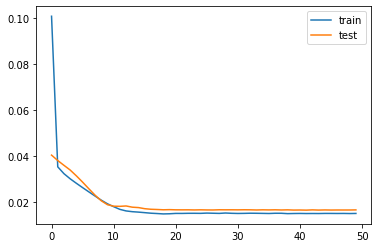

In [101]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
model.save('models/multivariate-ts-lstm.h5')
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
#model.save('multivariate-ts-lstm-01.h5')

In [103]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


In [104]:
#Evaluation: forcasted values vs. real values
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse,rmse
error1 = mse(inv_y, inv_yhat)
error2 = rmse(inv_y, inv_yhat)
error3 = mean_absolute_error(inv_y, inv_yhat)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(inv_y), np.array(inv_yhat)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

error4 = mean_absolute_percentage_error(inv_y, inv_yhat)

print(f'MAE Error: {error3:11.10}') 
print(f'MSE Error : {error1:11.10}')
print(f'RMSE Error: {error2:11.10}')
print(f'MAPE Error: {error4:11.10}')


MAE Error:   2.5163095
MSE Error :  19.8222599
RMSE Error: 4.452219486
MAPE Error: 6.303739548


In [105]:
dt 

7810    2019-06-15 00:00:00
7811    2019-06-15 00:30:00
7812    2019-06-15 01:00:00
7813    2019-06-15 01:30:00
7814    2019-06-15 02:00:00
               ...         
8525    2019-06-29 21:30:00
8526    2019-06-29 22:00:00
8527    2019-06-29 22:30:00
8528    2019-06-29 23:00:00
8529    2019-06-29 23:30:00
Name: datetime, Length: 720, dtype: object

In [106]:
test_data = {'dt':dt, 'test_val':inv_y}

In [107]:
test_data = pd.DataFrame(test_data)

In [108]:
pred_data = {'dt':dt,'predicted_val':inv_yhat }

In [109]:
pred_data = pd.DataFrame(pred_data)

In [110]:
pred_data

,dt,predicted_val
7810,2019-06-15 00:00:00,37.024181
7811,2019-06-15 00:30:00,40.230797
7812,2019-06-15 01:00:00,39.208580
7813,2019-06-15 01:30:00,39.633663
7814,2019-06-15 02:00:00,38.418888
...,...,...
8525,2019-06-29 21:30:00,52.178226
8526,2019-06-29 22:00:00,45.581409
8527,2019-06-29 22:30:00,45.002140
8528,2019-06-29 23:00:00,42.639572


In [111]:
test = test_data.set_index('dt').test_val

In [112]:
predictions = pred_data.set_index('dt').predicted_val

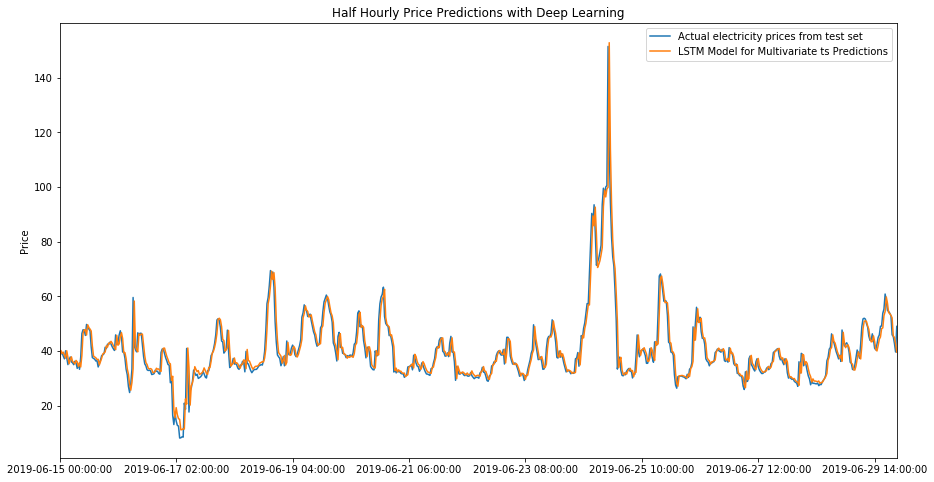

In [113]:
#Visualisations:
title = 'Half Hourly Price Predictions with Deep Learning'
ylabel='Price'
xlabel='' 
ax = test.rename('Actual electricity prices from test set').plot(legend=True,figsize=(15,8),title=title)
predictions.rename('LSTM Model for Multivariate ts Predictions').plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

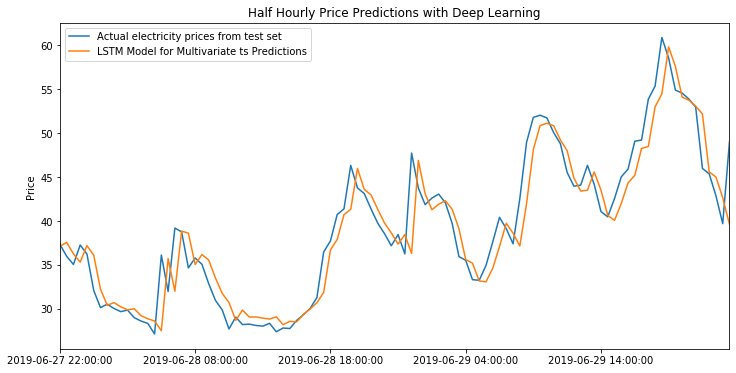

In [115]:
#Visualisations:
title = 'Half Hourly Price Predictions with Deep Learning'
ylabel='Price'
xlabel='' 
ax = test[-100:].rename('Actual electricity prices from test set').plot(legend=True,figsize=(12,6),title=title)
predictions[-100:].rename('LSTM Model for Multivariate ts Predictions').plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## LSTM with convolution layer on top for multivariate time series

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#window_size=60

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None,3]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


In [19]:
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
#history = model.fit(train_set,epochs=70)
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 7760 samples, validate on 768 samples
Epoch 1/100
7760/7760 - 4s - loss: 0.0881 - mae: 0.2344 - val_loss: 0.0043 - val_mae: 0.0688
Epoch 2/100
7760/7760 - 1s - loss: 0.0032 - mae: 0.0569 - val_loss: 0.0042 - val_mae: 0.0695
Epoch 3/100
7760/7760 - 1s - loss: 0.0023 - mae: 0.0488 - val_loss: 0.0041 - val_mae: 0.0684
Epoch 4/100
7760/7760 - 1s - loss: 0.0020 - mae: 0.0457 - val_loss: 0.0038 - val_mae: 0.0655
Epoch 5/100
7760/7760 - 1s - loss: 0.0018 - mae: 0.0440 - val_loss: 0.0036 - val_mae: 0.0644
Epoch 6/100
7760/7760 - 1s - loss: 0.0017 - mae: 0.0427 - val_loss: 0.0033 - val_mae: 0.0616
Epoch 7/100
7760/7760 - 1s - loss: 0.0017 - mae: 0.0420 - val_loss: 0.0030 - val_mae: 0.0582
Epoch 8/100
7760/7760 - 1s - loss: 0.0017 - mae: 0.0416 - val_loss: 0.0029 - val_mae: 0.0562
Epoch 9/100
7760/7760 - 1s - loss: 0.0016 - mae: 0.0415 - val_loss: 0.0028 - val_mae: 0.0543
Epoch 10/100
7760/7760 - 1s - loss: 0.0016 - mae: 0.0413 - val_loss: 0.0027 - val_mae: 0.0528
Epoch 11/100
7760/7760

In [0]:
from matplotlib import pyplot as plt
#optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

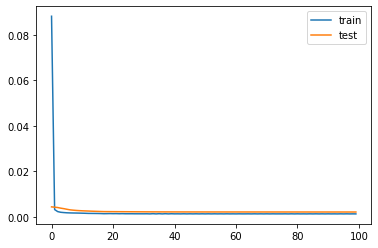

In [20]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.reshape(yhat.shape[0],yhat.shape[2])
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


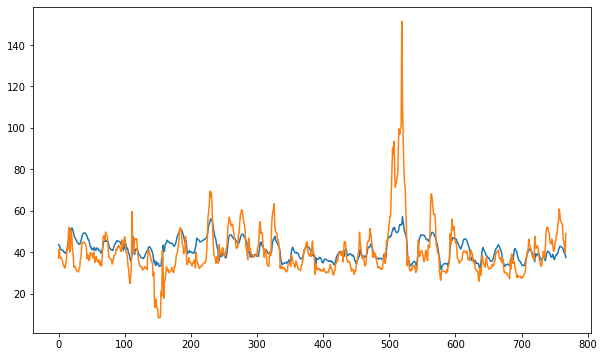

In [22]:
pyplot.figure(figsize=(10, 6))
pyplot.plot(inv_yhat)
pyplot.plot(inv_y)
pyplot.show()

In [94]:
#Evaluation: forcasted values vs. real values
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse,rmse
error1 = mse(inv_y, inv_yhat)
error2 = rmse(inv_y, inv_yhat)
error3 = mean_absolute_error(inv_y, inv_yhat)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(inv_y), np.array(inv_yhat)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

error4 = mean_absolute_percentage_error(inv_y, inv_yhat)

print(f'MAE Error: {error3:11.10}') 
print(f'MSE Error : {error1:11.10}')
print(f'RMSE Error: {error2:11.10}')
print(f'MAPE Error: {error4:11.10}')


MAE Error: 6.416340351
MSE Error : 95.23300934
RMSE Error: 9.758740425
MAPE Error: 17.38224179
